<h1 style="color:blue">1. Importation des bibliothèques</h1>

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns
import plotly.express as px

<h1 style="color:blue">2. Découverte des données</h1>

In [10]:
 df = pd.read_excel("C:/Users/hanaa.talbi/Downloads/PRM/PRMAggregated.xlsx")

df.columns = df.columns.str.strip().str.replace(" ", "_").str.replace(".", "", regex=False)
df['date_heure'] = pd.to_datetime(
    df['Day_of_ScheduledDateTime_Local'].astype(str) + ' ' + df['Time'].astype(str),
    format="%Y-%m-%d %H:%M:%S",
    errors='coerce'
)

<h1 style="color:blue">3. Gestion des valeurs manquantes</h1>

In [11]:
# Impute missing Avg_Seat_Load_Factor
s = df['Avg_Seat_Load_Factor'].isna() & df['Passengers'].notna() & df['MaxPax_MostConfident'].notna()
df.loc[s, 'Avg_Seat_Load_Factor'] = df.loc[s, 'Passengers'] / df.loc[s, 'MaxPax_MostConfident']

# Impute missing Passengers
p = df['Passengers'].isna() & df['Avg_Seat_Load_Factor'].notna() & df['MaxPax_MostConfident'].notna()
df.loc[p, 'Passengers'] = df.loc[p, 'Avg_Seat_Load_Factor'] * df.loc[p, 'MaxPax_MostConfident']

m = df['MaxPax_MostConfident'].isna() & df['Avg_Seat_Load_Factor'].notna() & df['Passengers'].notna()
df.loc[m, 'MaxPax_MostConfident'] = df.loc[m, 'Passengers'] / df.loc[m, 'Avg_Seat_Load_Factor']

# Recalculate Avg_Seat_Load_Factor 
df['Avg_Seat_Load_Factor'] = df['Avg_Seat_Load_Factor'].fillna(df['Passengers'] / df['MaxPax_MostConfident'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112860 entries, 0 to 112859
Data columns (total 8 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   Day_of_ScheduledDateTime_Local  112860 non-null  object        
 1   Time                            112860 non-null  object        
 2   Count_of_FlightPerformance      88043 non-null   float64       
 3   MaxPax_MostConfident            87896 non-null   float64       
 4   Passengers                      87972 non-null   float64       
 5   Avg_Seat_Load_Factor            87880 non-null   float64       
 6   PRMs                            75431 non-null   float64       
 7   date_heure                      0 non-null       datetime64[ns]
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 6.9+ MB


In [12]:
# On garde les lignes utiles
colonnes_utiles = ['PRMs', 'Passengers', 'Avg_Seat_Load_Factor', 'MaxPax_MostConfident', 'Count_of_FlightPerformance']
df = df.dropna(how='all', subset=colonnes_utiles)

In [13]:
vars_expl = ["Passengers", "Avg_Seat_Load_Factor", "MaxPax_MostConfident", "Count_of_FlightPerformance"]
 
df["PRMs"] = df["PRMs"].ffill().bfill()
for col in vars_expl:
    df[col] = df[col].fillna(df[col].median())#remplace les valeurs manquantes par leurs mediane 


<h1 style="color:blue">4. Traitement des outliers</h1>

In [14]:
from sklearn.ensemble import IsolationForest
from sklearn.impute import KNNImputer

In [15]:

# 1. ANALYSE DES OUTLIERS
print("1. ANALYSE DES OUTLIERS")

# Fonction pour identifier les outliers avec la méthode IQR
def identify_outliers_iqr(df, col):
    """
    Identifie les outliers d'une colonne en utilisant la méthode IQR (Interquartile Range)
    Les valeurs au-delà de Q1-1.5*IQR et Q3+1.5*IQR sont considérées comme des outliers
    """
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = max(Q1 - 1.5 * IQR, 0)
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
    
    result = {
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'outliers_count': len(outliers),
        'outliers_percentage': (len(outliers) / len(df)) * 100,
        'min_value': df[col].min(),
        'max_value': df[col].max()
    }
    
    return result

numeric_cols_of_interest = ['MaxPax_MostConfident', 'Passengers', 'Avg_Seat_Load_Factor', 'PRMs', 'Count_of_FlightPerformance' ]

for col in numeric_cols_of_interest:
    outliers_info = identify_outliers_iqr(df, col)
    print(f"Outliers pour {col}:")
    print(f"  - Plage normale: [{outliers_info['lower_bound']:.2f}, {outliers_info['upper_bound']:.2f}]")
    print(f"  - Valeurs extrêmes observées: [{outliers_info['min_value']:.2f}, {outliers_info['max_value']:.2f}]")
    print(f"  - Nombre d'outliers: {outliers_info['outliers_count']} ({outliers_info['outliers_percentage']:.2f}%)")

1. ANALYSE DES OUTLIERS
Outliers pour MaxPax_MostConfident:
  - Plage normale: [0.00, 1501.00]
  - Valeurs extrêmes observées: [0.00, 2319.00]
  - Nombre d'outliers: 1690 (1.92%)
Outliers pour Passengers:
  - Plage normale: [0.00, 1323.50]
  - Valeurs extrêmes observées: [0.00, 2194.00]
  - Nombre d'outliers: 1521 (1.73%)
Outliers pour Avg_Seat_Load_Factor:
  - Plage normale: [0.50, 1.14]
  - Valeurs extrêmes observées: [0.00, 1.06]
  - Nombre d'outliers: 3221 (3.66%)
Outliers pour PRMs:
  - Plage normale: [0.00, 14.50]
  - Valeurs extrêmes observées: [0.00, 64.00]
  - Nombre d'outliers: 3648 (4.14%)
Outliers pour Count_of_FlightPerformance:
  - Plage normale: [0.00, 9.50]
  - Valeurs extrêmes observées: [1.00, 14.00]
  - Nombre d'outliers: 857 (0.97%)


2. VISUALISATION DÉTAILLÉE DES OUTLIERS


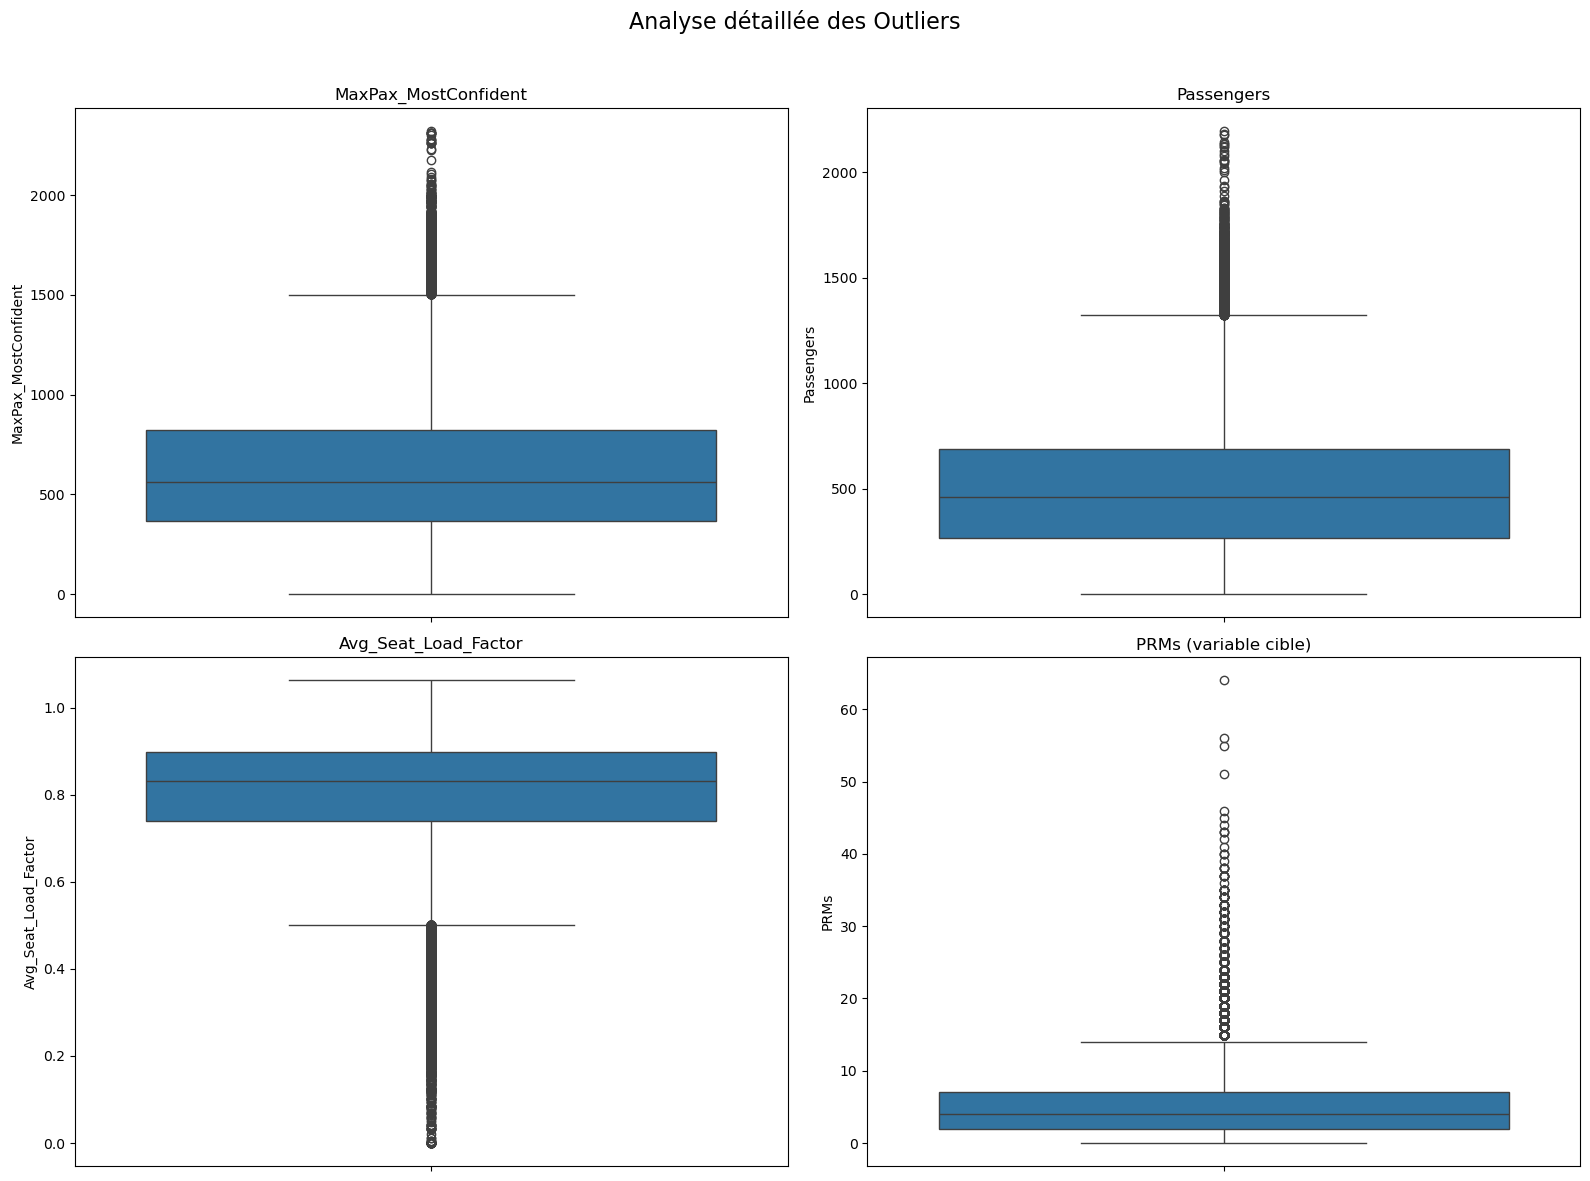

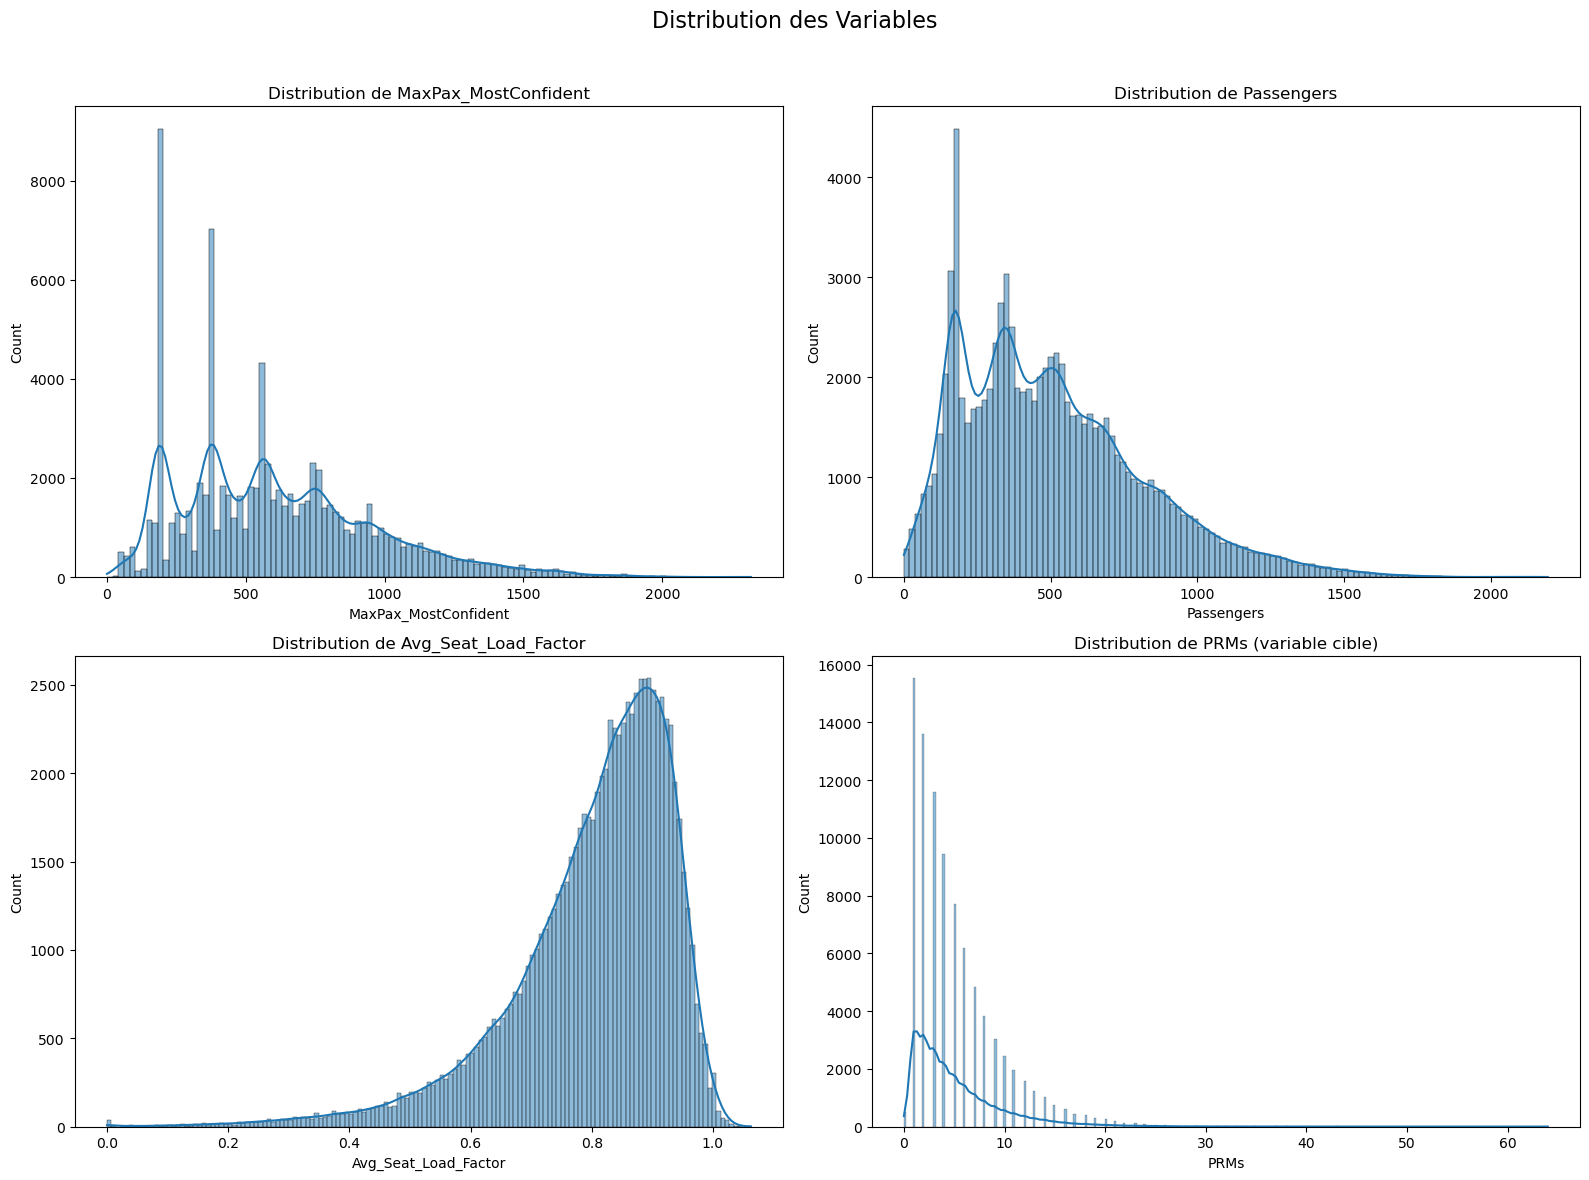

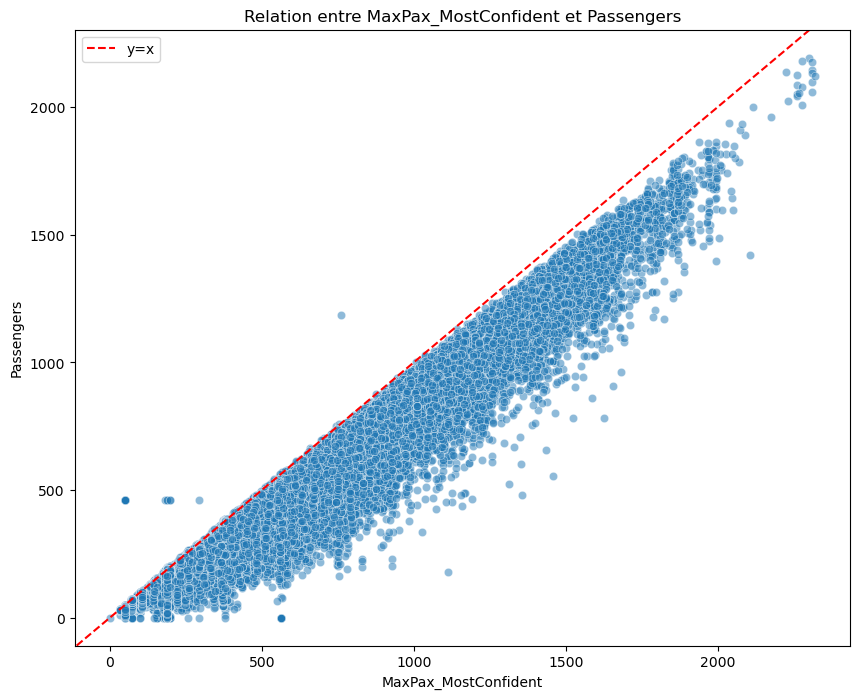

In [17]:
# 2. VISUALISATION DÉTAILLÉE DES OUTLIERS
print("2. VISUALISATION DÉTAILLÉE DES OUTLIERS")

# Créer une figure avec multiple sous-graphiques pour analyser les outliers
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Analyse détaillée des Outliers', fontsize=16)

# MaxPax_MostConfident
sns.boxplot(ax=axes[0, 0], y=df['MaxPax_MostConfident'])
axes[0, 0].set_title('MaxPax_MostConfident')

# Passengers
sns.boxplot(ax=axes[0, 1], y=df['Passengers'])
axes[0, 1].set_title('Passengers')

# Avg_Seat_Load_Factor
sns.boxplot(ax=axes[1, 0], y=df['Avg_Seat_Load_Factor'])
axes[1, 0].set_title('Avg_Seat_Load_Factor')

# PRMs (variable cible)
sns.boxplot(ax=axes[1, 1], y=df['PRMs'])
axes[1, 1].set_title('PRMs (variable cible)')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Créer des histogrammes pour mieux comprendre la distribution
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Distribution des Variables', fontsize=16)

# MaxPax_MostConfident
sns.histplot(ax=axes[0, 0], data=df, x='MaxPax_MostConfident', kde=True)
axes[0, 0].set_title('Distribution de MaxPax_MostConfident')

# Passengers
sns.histplot(ax=axes[0, 1], data=df, x='Passengers', kde=True)
axes[0, 1].set_title('Distribution de Passengers')

# Avg_Seat_Load_Factor
sns.histplot(ax=axes[1, 0], data=df, x='Avg_Seat_Load_Factor', kde=True)
axes[1, 0].set_title('Distribution de Avg_Seat_Load_Factor')

# PRMs (variable cible)
sns.histplot(ax=axes[1, 1], data=df, x='PRMs', kde=True)
axes[1, 1].set_title('Distribution de PRMs (variable cible)')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Ajouter un scatter plot pour analyser la relation entre Passengers et MaxPax_MostConfident
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x='MaxPax_MostConfident', y='Passengers', alpha=0.5)
plt.title('Relation entre MaxPax_MostConfident et Passengers')
plt.xlabel('MaxPax_MostConfident')
plt.ylabel('Passengers')
plt.axline([0, 0], [1, 1], color='red', linestyle='--', label='y=x')
plt.legend()
plt.show()

In [20]:
# 3. TRAITEMENT DES OUTLIERS PAR VARIABLE
print("3. TRAITEMENT DES OUTLIERS PAR VARIABLE")


# 3.1 Traitement pour MaxPax_MostConfident
print("3.1 Traitement pour MaxPax_MostConfident:")

# Identifier les outliers
Q1_maxpax = df['MaxPax_MostConfident'].quantile(0.25)
Q3_maxpax = df['MaxPax_MostConfident'].quantile(0.75)
IQR_maxpax = Q3_maxpax - Q1_maxpax
upper_bound_maxpax = Q3_maxpax + 1.5 * IQR_maxpax
lower_bound_maxpax = max(Q1_maxpax - 1.5 * IQR_maxpax,0)

# Appliquer une transformation logarithmique 

df['MaxPax_MostConfident_log'] = np.log1p(df['MaxPax_MostConfident'])

print(f"  - Plage normale: [{lower_bound_maxpax:.2f}, {upper_bound_maxpax:.2f}]")
print(f"  - Nombre d'outliers: {len(df[df['MaxPax_MostConfident'] > upper_bound_maxpax])}")


# 3.2 Traitement pour Passengers
print("3.2 Traitement pour Passengers:")

# Identifier les outliers
Q1_pass = df['Passengers'].quantile(0.25)
Q3_pass = df['Passengers'].quantile(0.75)
IQR_pass = Q3_pass - Q1_pass
upper_bound_pass = Q3_pass + 1.5 * IQR_pass
lower_bound_pass = max(Q1_pass - 1.5 * IQR_pass, 0)

# Appliquer une transformation logarithmique
df['Passengers_log'] = np.log1p(df['Passengers'])

# Vérifier si le nombre de passagers dépasse la capacité maximale
inconsistencies = df[df['Passengers'] > df['MaxPax_MostConfident']]
print(f"  - Plage normale: [{lower_bound_pass:.2f}, {upper_bound_pass:.2f}]")
print(f"  - Nombre d'outliers: {len(df[df['Passengers'] > upper_bound_pass])}")
print(f"  - Vols où Passengers > MaxPax_MostConfident: {len(inconsistencies)} ({len(inconsistencies)/len(df)*100:.2f}%)")

# plafonner les passagers à la capacité maximale
df['Passengers_corrected'] = df['Passengers'].copy()
mask_excess = df['Passengers'] > df['MaxPax_MostConfident']
df.loc[mask_excess, 'Passengers_corrected'] = df.loc[mask_excess, 'MaxPax_MostConfident']

# 3.3 Traitement pour Avg_Seat_Load_Factor
print("3.3 Traitement pour Avg_Seat_Load_Factor:")

# Identifier les valeurs impossibles (>1 ou 100%)
impossible_values = df[df['Avg_Seat_Load_Factor'] > 1.0]
print(f"  - Nombre de vols avec taux de remplissage > 1.0: {len(impossible_values)} ({len(impossible_values)/len(df)*100:.2f}%)")
print(f"  - Valeur maximale observée: {df['Avg_Seat_Load_Factor'].max():.2f}")

# plafonner à 1
df['Avg_Seat_Load_Factor_corrected'] = df['Avg_Seat_Load_Factor'].copy()
df.loc[df['Avg_Seat_Load_Factor'] > 1.0, 'Avg_Seat_Load_Factor_corrected'] = 1.0 

# Recalculer Avg_Seat_Load_Factor pour les lignes où Passengers a été corrigé
mask_recalc = df['Passengers'] != df['Passengers_corrected']
df.loc[mask_recalc, 'Avg_Seat_Load_Factor_corrected'] = df.loc[mask_recalc, 'Passengers_corrected'] / df.loc[mask_recalc, 'MaxPax_MostConfident']

# 3.4 Traitement pour PRMs (variable cible)
print("3.4 Traitement pour PRMs (variable cible):")

# Identifier les outliers
Q1_prm = df['PRMs'].quantile(0.25)
Q3_prm = df['PRMs'].quantile(0.75)
IQR_prm = Q3_prm - Q1_prm
upper_bound_prm = Q3_prm + 1.5 * IQR_prm
lower_bound_prm = max(Q1_prm - 1.5 * IQR_prm,0)

# Appliquer une transformation logarithmique 
df['PRMs_log'] = np.log1p(df['PRMs'])
print(f"PRMs: transformation logarithmique appliquée")
# Conserver PRMs original car c'est la variable cible




3. TRAITEMENT DES OUTLIERS PAR VARIABLE
3.1 Traitement pour MaxPax_MostConfident:
  - Plage normale: [0.00, 1501.00]
  - Nombre d'outliers: 1690
3.2 Traitement pour Passengers:
  - Plage normale: [0.00, 1323.50]
  - Nombre d'outliers: 1521
  - Vols où Passengers > MaxPax_MostConfident: 360 (0.41%)
3.3 Traitement pour Avg_Seat_Load_Factor:
  - Nombre de vols avec taux de remplissage > 1.0: 299 (0.34%)
  - Valeur maximale observée: 1.06
3.4 Traitement pour PRMs (variable cible):
PRMs: transformation logarithmique appliquée


4. DÉTECTION MULTIVARIÉE DES OUTLIERS AVEC ISOLATION FOREST
Number of outliers detected: 2642 (3.00%)
Number of normal samples detected: 85401 (97.00%)


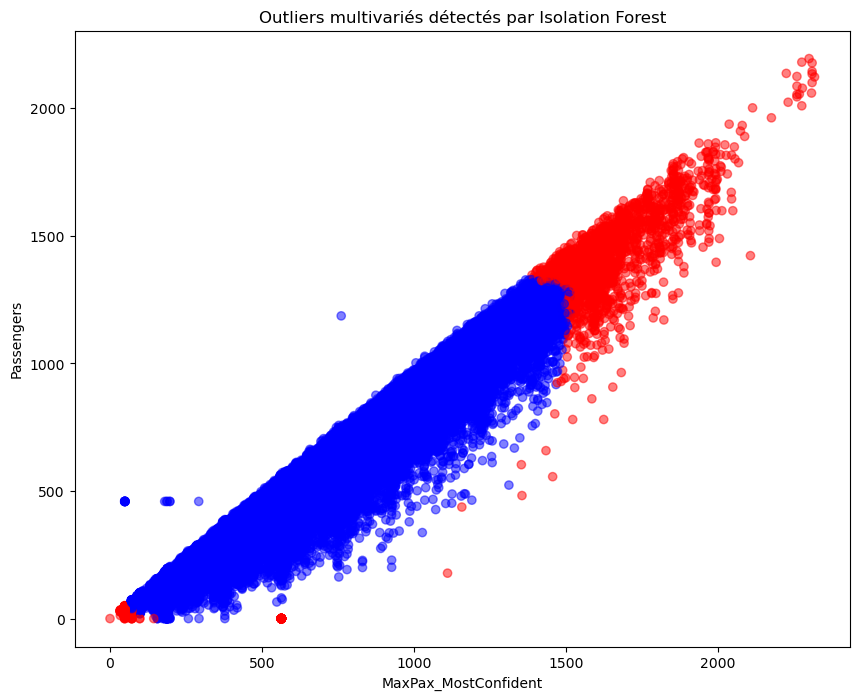

In [21]:
# 4. DÉTECTION MULTIVARIÉE DES OUTLIERS AVEC ISOLATION FOREST
print("4. DÉTECTION MULTIVARIÉE DES OUTLIERS AVEC ISOLATION FOREST")

# Sélectionner les variables numériques pertinentes
features_for_isolation = ['MaxPax_MostConfident', 'Passengers']
X = df[features_for_isolation]

imputer = KNNImputer(n_neighbors=5)
X_imputed = imputer.fit_transform(X)


# Initialiser et entraîner le modèle Isolation Forest
prediction = IsolationForest(contamination=0.03,n_estimators=100, random_state=42, n_jobs=-1)
df['outlier_scores'] = prediction.fit_predict(X_imputed) # Le fit_predict retourne 1 pour les points normaux et -1 pour les anomalies
df['is_outlier'] = df['outlier_scores'] == -1

print(f"Number of outliers detected: {df['is_outlier'].sum()} ({df['is_outlier'].mean()*100:.2f}%)")
print(f"Number of normal samples detected: {(df['outlier_scores'] > 0).sum()} ({(df['outlier_scores'] > 0).mean()*100:.2f}%)")

plt.figure(figsize=(10, 8))
colors = ['red' if outlier else 'blue' for outlier in df['is_outlier']]
plt.scatter(df['MaxPax_MostConfident'], df['Passengers'], 
           c=colors, alpha=0.5)
plt.title('Outliers multivariés détectés par Isolation Forest')
plt.xlabel('MaxPax_MostConfident')
plt.ylabel('Passengers')
plt.show()

6. VISUALISATION DES DONNÉES APRÈS TRAITEMENT


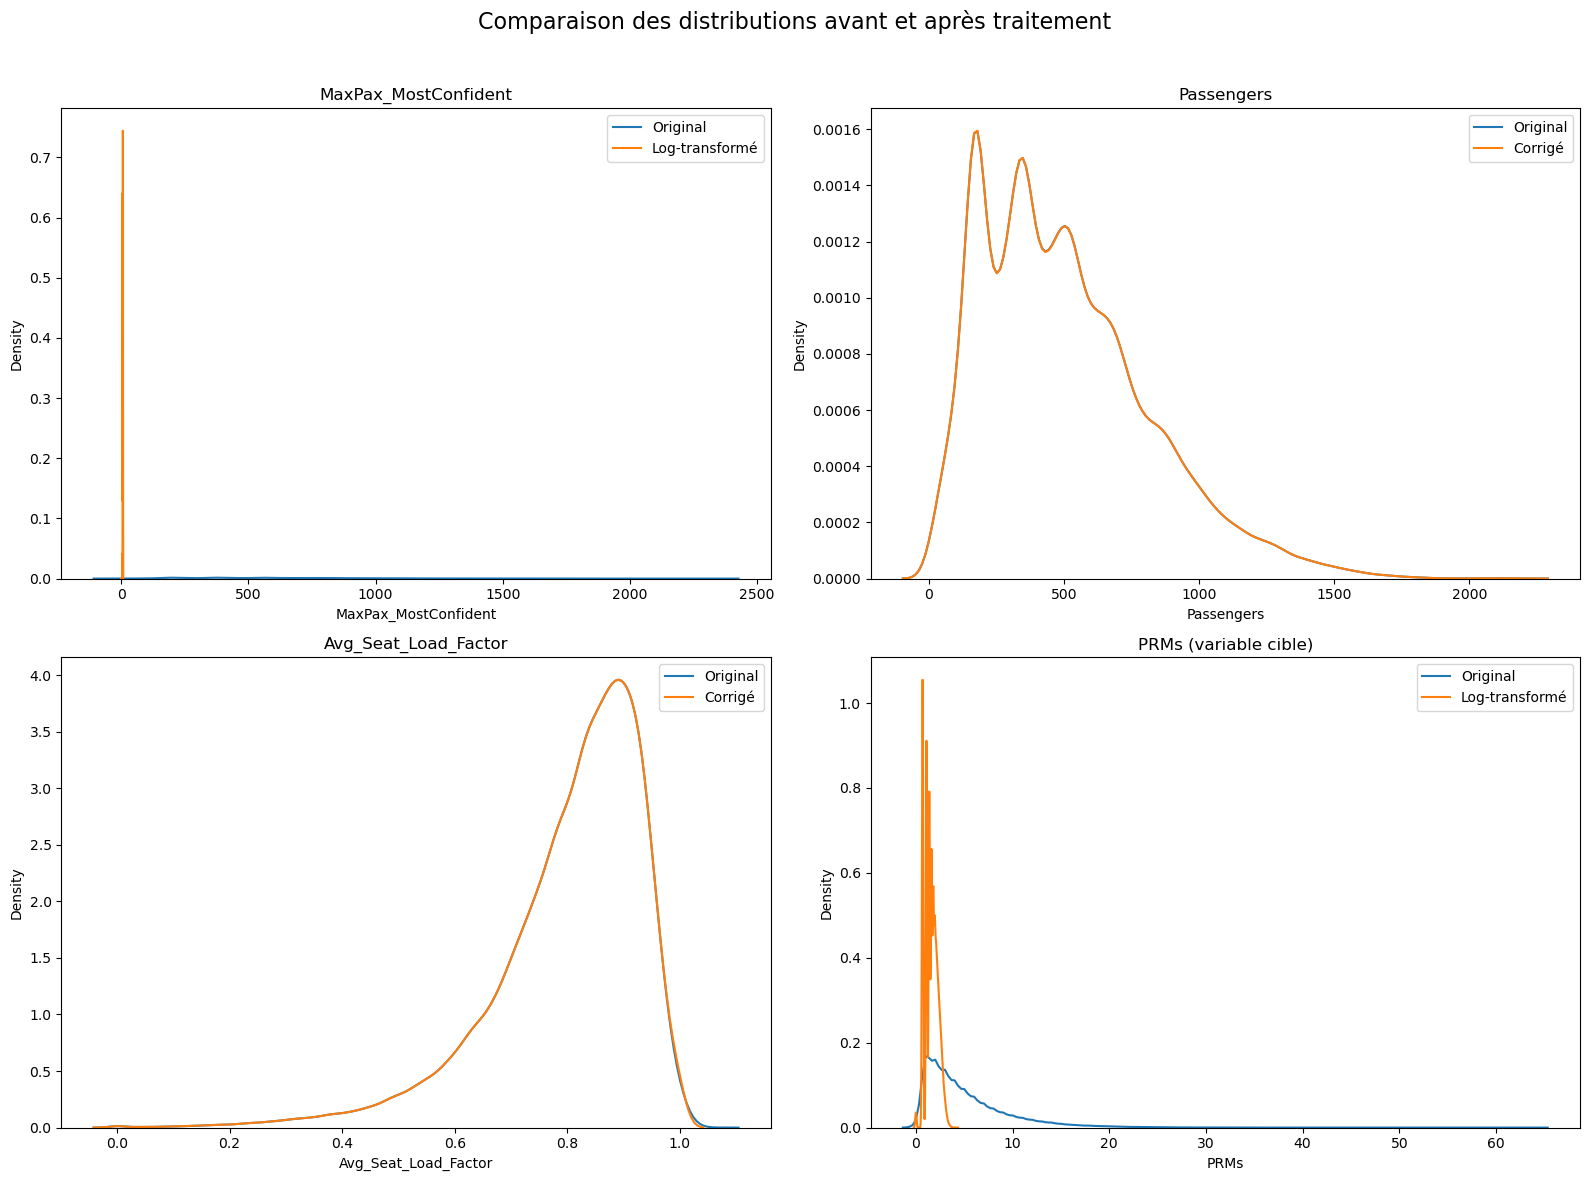

In [22]:
# 5. VISUALISATION DES DONNÉES APRÈS TRAITEMENT

print("6. VISUALISATION DES DONNÉES APRÈS TRAITEMENT")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Comparaison des distributions avant et après traitement', fontsize=16)

# MaxPax_MostConfident
sns.kdeplot(ax=axes[0, 0], data=df, x='MaxPax_MostConfident', label='Original')
sns.kdeplot(ax=axes[0, 0], data=df, x='MaxPax_MostConfident_log', label='Log-transformé')
axes[0, 0].set_title('MaxPax_MostConfident')
axes[0, 0].legend()

# Passengers
sns.kdeplot(ax=axes[0, 1], data=df, x='Passengers', label='Original')
sns.kdeplot(ax=axes[0, 1], data=df, x='Passengers_corrected', label='Corrigé')
axes[0, 1].set_title('Passengers')
axes[0, 1].legend()

# Avg_Seat_Load_Factor
sns.kdeplot(ax=axes[1, 0], data=df, x='Avg_Seat_Load_Factor', label='Original')
sns.kdeplot(ax=axes[1, 0], data=df, x='Avg_Seat_Load_Factor_corrected', label='Corrigé')
axes[1, 0].set_title('Avg_Seat_Load_Factor')
axes[1, 0].legend()

# PRMs
sns.kdeplot(ax=axes[1, 1], data=df, x='PRMs', label='Original')
sns.kdeplot(ax=axes[1, 1], data=df, x='PRMs_log', label='Log-transformé')
axes[1, 1].set_title('PRMs (variable cible)')
axes[1, 1].legend()  
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

<h1 style="color:blue">4. Filtre de Kalman</h1>

In [23]:
df["log_PRMs"] = np.log1p(df["PRMs"])

In [24]:

# Cree la matrice x et y 
X = df[vars_expl].values
y = df["log_PRMs"].values

taille_train = int(len(df) * 0.8)
X_entrainement = X[:taille_train]
y_entrainement = y[:taille_train]
X_test = X[taille_train:]
y_test = y[taille_train:]
index_test = df.index[taille_train:]

# on initialise 
nb_vars = X_entrainement.shape[1]
etats_estimes = []
covariances = []
etat_actuel = np.zeros(nb_vars)
cov_actuelle = np.eye(nb_vars)

# boucle filtrage sur entrainement
for t in range(len(y_entrainement)):
    filtre = KalmanFilter(
        transition_matrices=np.eye(nb_vars),
        observation_matrices=X_entrainement[t:t+1],
        initial_state_mean=etat_actuel,
        initial_state_covariance=cov_actuelle,
        observation_covariance=1.0,
        transition_covariance=0.01 * np.eye(nb_vars)
    )
    etat_actuel, cov_actuelle = filtre.filter_update(
        etat_actuel,
        cov_actuelle,
        observation=y_entrainement[t]
    )
    etats_estimes.append(etat_actuel)
    covariances.append(cov_actuelle)

etats_estimes = np.array(etats_estimes)


In [25]:
#  prediction sur entraçnement
pred_log_entrainement = np.sum(X_entrainement * etats_estimes, axis=1)
pred_entrainement = np.expm1(pred_log_entrainement)

# nettoyage des donnee de test(ça jsp c'est quoi y'avait une erreur donc j'ai mis ça) 
masque_valide = ~np.isnan(X_test).any(axis=1) & ~np.isnan(y_test)
X_test = X_test[masque_valide]
y_test = y_test[masque_valide]
index_test = index_test[masque_valide]

#  prediction sur le test  mais avec le dernier etat que l'on a estimé
etat_final = etats_estimes[-1]
pred_log_test = X_test @ etat_final
pred_test = np.expm1(pred_log_test)
y_test_reel = np.expm1(y_test)





In [26]:
print("Erreur quadratique moyenne :", mean_squared_error(y_test_reel, pred_test))
print("Erreur absolue moyenne :", mean_absolute_error(y_test_reel, pred_test))

()
plt.show()

Erreur quadratique moyenne : 18.960807352289624
Erreur absolue moyenne : 3.0370106307847147


In [27]:
print("Erreur quadratique moyenne :", mean_squared_error(y_test_reel, pred_test))
print("Erreur absolue moyenne :", mean_absolute_error(y_test_reel, pred_test))

petits = y_test_reel <= 10
grands = y_test_reel > 20
print("MAE pour PRMs ≤ 10 :", mean_absolute_error(y_test_reel[petits], pred_test[petits]))
print("MAE pour PRMs > 20 :", mean_absolute_error(y_test_reel[grands], pred_test[grands]))

Erreur quadratique moyenne : 18.960807352289624
Erreur absolue moyenne : 3.0370106307847147
MAE pour PRMs ≤ 10 : 2.1848782168511227
MAE pour PRMs > 20 : 11.780759982753185


MAE pour PRMs ≤ 10 : 2.1848782168511227
MAE pour PRMs > 20 : 11.780759982753185


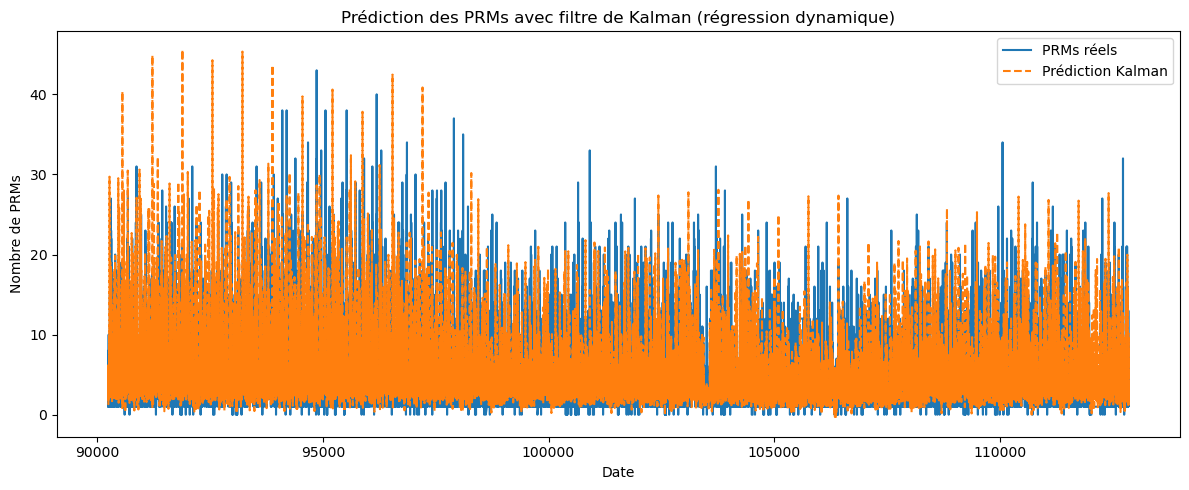

In [28]:
petits = y_test_reel <= 10
grands = y_test_reel > 20
print("MAE pour PRMs ≤ 10 :", mean_absolute_error(y_test_reel[petits], pred_test[petits]))
print("MAE pour PRMs > 20 :", mean_absolute_error(y_test_reel[grands], pred_test[grands]))

plt.figure(figsize=(12, 5))
plt.plot(index_test, y_test_reel, label="PRMs réels")
plt.plot(index_test, pred_test, label="Prédiction Kalman", linestyle="--")
plt.title("Prédiction des PRMs avec filtre de Kalman (régression dynamique)")
plt.xlabel("Date")
plt.ylabel("Nombre de PRMs")
plt.legend()
plt.tight_layout()
plt.show()

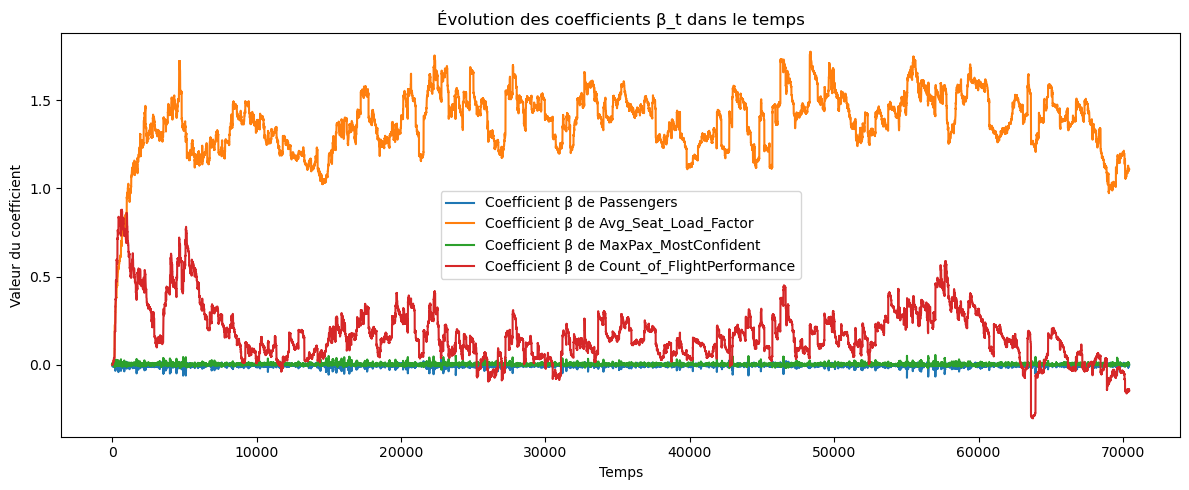

In [29]:
plt.figure(figsize=(12, 5))
for i, var in enumerate(vars_expl):
    plt.plot(etats_estimes[:, i], label=f"Coefficient β de {var}")
plt.title("Évolution des coefficients β_t dans le temps")
plt.xlabel("Temps")
plt.ylabel("Valeur du coefficient")
plt.legend()
plt.tight_layout()
plt.show()

In [30]:
liste_pred_test = np.round(pred_test,0).tolist()
liste_y_test_reel = y_test_reel.tolist()

In [31]:
vraie_valeur_liste = df['PRMs'].tolist()

In [32]:
resultat = pd.DataFrame({'vrai_valeur' : liste_y_test_reel, 'prediction' : liste_pred_test})

In [33]:
mae = mean_absolute_error(resultat["vrai_valeur"], resultat["prediction"])
print(f"MAE : {mae:.2f}")
rmse = np.sqrt(mean_squared_error(resultat["vrai_valeur"], resultat["prediction"]))
print(f"RMSE : {rmse:.2f}")

MAE : 3.02
RMSE : 4.36


In [34]:
def classer(pred):
    if pred == 0:
        return "0"
    elif 1<= pred <= 5:
        return "1-5"
    elif 6 <= pred <= 20:
        return "6-20"
    elif 20 <=pred <= 64:
        return "21-64" #pcq 64 c'etait le max de PRMs en vrai
    else:
        return "Impossible"


In [35]:
resultat['classe_vrai'] = resultat['vrai_valeur'].apply(classer)
resultat['classe_pred'] = resultat['prediction'].apply(classer)

In [36]:
resultat['bonne_classification'] =  resultat.apply(lambda x: 1 if x['classe_vrai'] == x['classe_pred'] else 0, axis=1)

In [37]:
resultat

,vrai_valeur,prediction,classe_vrai,classe_pred,bonne_classification
0,1.0,3.0,1-5,1-5,1
1,3.0,3.0,1-5,1-5,1
2,3.0,5.0,1-5,1-5,1
3,3.0,4.0,1-5,1-5,1
4,4.0,6.0,1-5,6-20,0
...,...,...,...,...,...
17604,3.0,2.0,1-5,1-5,1
17605,3.0,1.0,1-5,1-5,1
17606,3.0,3.0,1-5,1-5,1
17607,3.0,3.0,1-5,1-5,1


In [38]:
resultat[resultat['bonne_classification'] == 1]['bonne_classification'].sum()

11536

In [39]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(resultat['classe_vrai'], resultat['classe_pred'])
conf_matrix_percent = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis] * 100

In [40]:
import seaborn as sns

Text(0.5, 23.52222222222222, 'Classe prédite')

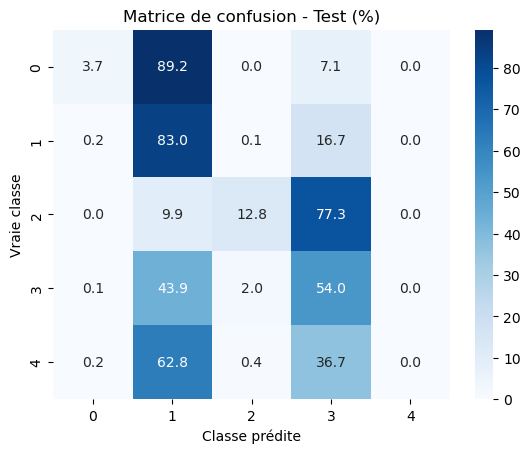

In [41]:
sns.heatmap(conf_matrix_percent, annot=True, fmt='.1f', cmap='Blues')
plt.title('Matrice de confusion - Test (%)')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')

In [42]:
#0 impossible (classe 4)
# par compte prédit très mal les 0 : certainement mauvaise distinction entre 0 et 1